In [5]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

train.h5:  15%|#4        | 1.58G/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

In [2]:
import os
import h5py
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import IPython
from skimage.transform import resize
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import torch.nn.functional as FF
from scipy.optimize import linear_sum_assignment

import random
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from surprise_functions import *
from lightning_prediction import *

# Surprise Task 3

surprise_task3.h5:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ Dataset downloaded: data/surprise_task3.h5
First Event ID: S839048
vis: Shape=(384, 384, 36), DataType=int16
ir069: Shape=(192, 192, 36), DataType=int16
ir107: Shape=(192, 192, 36), DataType=int16
vil: Shape=(384, 384, 36), DataType=uint8


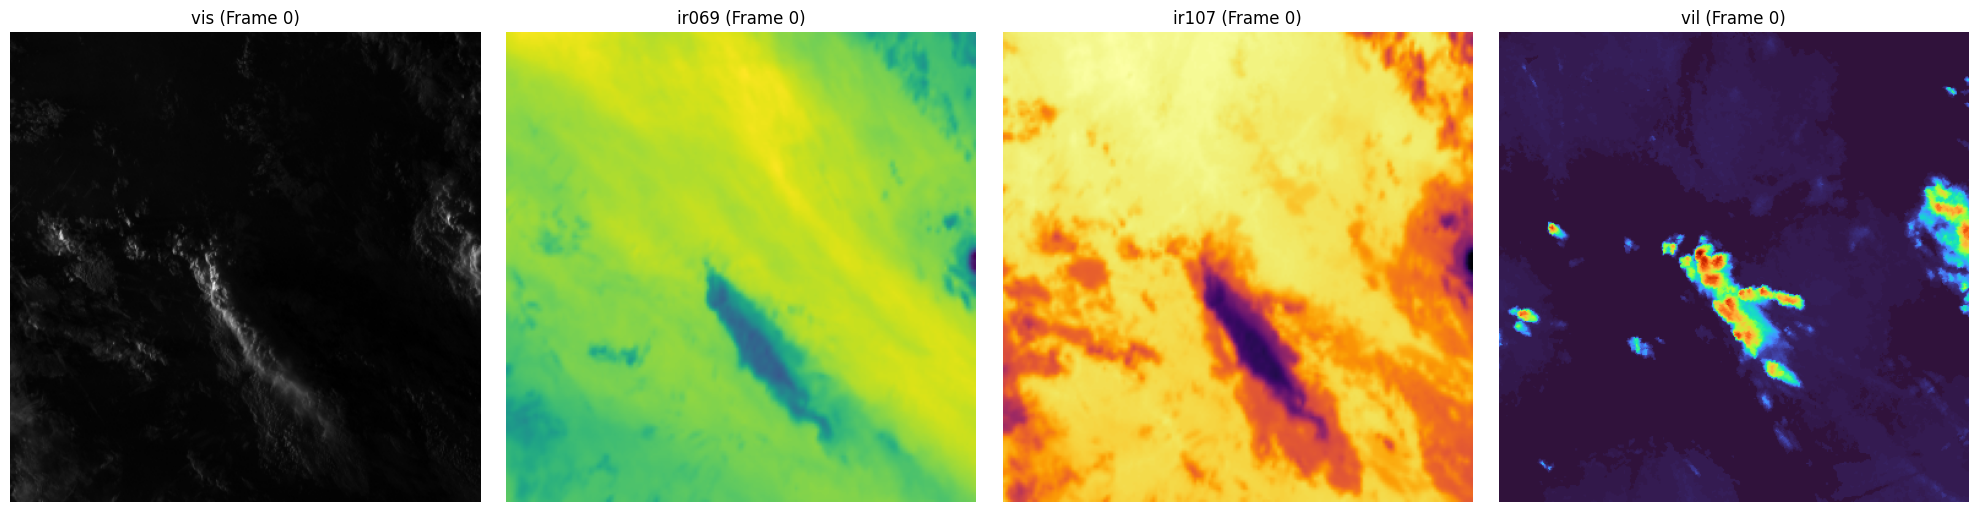

In [3]:
from huggingface_hub import hf_hub_download
import h5py
import matplotlib.pyplot as plt

# **Step 1: Download the dataset**
file_path = hf_hub_download(
    repo_id="benmoseley/ese-dl-2024-25-group-project",
    filename="surprise_task3.h5",
    repo_type="dataset",
    local_dir="data"
)

print("✅ Dataset downloaded:", file_path)

# **Step 2: Load the first event and print image shapes**
with h5py.File(file_path, 'r') as f:
    event_id = list(f.keys())[0]  # Get the first event ID
    print(f"First Event ID: {event_id}")

    # Load all image types
    event = {img_type: f[event_id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil']}

# **Print image shapes & data types**
for img_type, img_data in event.items():
    print(f"{img_type}: Shape={img_data.shape}, DataType={img_data.dtype}")

# **Step 3: Visualize the first frame of each channel**
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define colormaps for better visualization
colormaps = {
    "vis": "gray",
    "ir069": "viridis",
    "ir107": "inferno",
    "vil": "turbo"
}

for idx, (img_type, cmap) in enumerate(colormaps.items()):
    axes[idx].imshow(event[img_type][:, :, 0], cmap=cmap)
    axes[idx].set_title(f"{img_type} (Frame 0)")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [6]:
import h5py
import numpy as np

# **Step 1: Load training data & pick a random event's lightning data**
with h5py.File("data/train.h5", "r") as train_file:
    train_event_ids = list(train_file.keys())
    sample_event_id = train_event_ids[0]  # Select the first event (change if needed)
    fake_lght = train_file[sample_event_id]["lght"][:]  # Copy lightning data

print(f"✅ Using lightning data from {sample_event_id}, Shape: {fake_lght.shape}")

# **Step 2: Load test dataset and add `lght` to each event**
surprise_path = "data/surprise_task3.h5"
with h5py.File(surprise_path, "a") as test_file:  # Open in append mode
    test_event_ids = list(test_file.keys())

    for event_id in test_event_ids:
        if "lght" in test_file[event_id]:
            del test_file[event_id]["lght"]  # Remove existing if any

        test_file[event_id].create_dataset("lght", data=fake_lght)  # Add copied lightning data

print(f"✅ Fake lightning data added to {len(test_event_ids)} test events!")

✅ Using lightning data from S767475, Shape: (33131, 5)
✅ Fake lightning data added to 10 test events!


In [7]:

import h5py

# **Open the modified test dataset**
surprise_path = "data/surprise_task3.h5"

with h5py.File(surprise_path, "r") as test_file:
    test_event_ids = list(test_file.keys())  # Get all event IDs

    # **Print dataset shapes for first event**
    first_event = test_event_ids[5]
    print(f"✅ Event ID: {first_event}")

    for img_type in test_file[first_event]:
        print(f"{img_type}: {test_file[first_event][img_type].shape} ({test_file[first_event][img_type].dtype})")

    # **Check if `lght` exists in all events**
    lght_shapes = [test_file[event_id]["lght"].shape for event_id in test_event_ids if "lght" in test_file[event_id]]
    print(f"\n✅ Lightning (`lght`) added to {len(lght_shapes)} / {len(test_event_ids)} events!")
    print(f"Example `lght` Shape: {lght_shapes[0] if lght_shapes else 'Not Found'}")


✅ Event ID: S847595
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
lght: (33131, 5) (float32)
vil: (384, 384, 36) (uint8)
vis: (384, 384, 36) (int16)

✅ Lightning (`lght`) added to 10 / 10 events!
Example `lght` Shape: (33131, 5)


In [8]:
import h5py
from torch.utils.data import DataLoader

# Open the dataset file
with h5py.File(f"data/surprise_task3.h5", "r") as h5_file:
    test_event_ids = list(h5_file.keys())  # Get all event IDs
    print(f"Loaded {len(test_event_ids)} test events!")

    # Initialize test dataset using the original LightningDataset class
    test_dataset = LightningDataset(h5_file, event_ids=test_event_ids)

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Verify by checking a sample batch
sample_inputs, sample_targets = next(iter(test_loader))
print("Test Batch Shape (Inputs):", sample_inputs.shape)
print("Test Batch Shape (Targets):", sample_targets.shape)

Loaded 10 test events!
Test Batch Shape (Inputs): torch.Size([128, 4, 384, 384])
Test Batch Shape (Targets): torch.Size([128])


In [10]:
import torch

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model architecture
model = LightningCNN().to(device)  # Move model to the correct device

# Load the saved weights
model.load_state_dict(torch.load("lightning_cnn-60.pth", map_location=device))

# Switch model to evaluation mode
model.eval()

print("Model successfully loaded!")

Model successfully loaded!


<ipython-input-10-2aa5357d2c99>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lightning_cnn-60.pth", map_location=device))


In [12]:


# Switch model to evaluation mode
model.eval()

actual_counts = []
predicted_counts = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device),  targets.to(device)
        outputs = model(inputs).cpu().numpy()

        actual_counts.extend(targets.cpu().numpy())
        predicted_counts.extend(outputs)



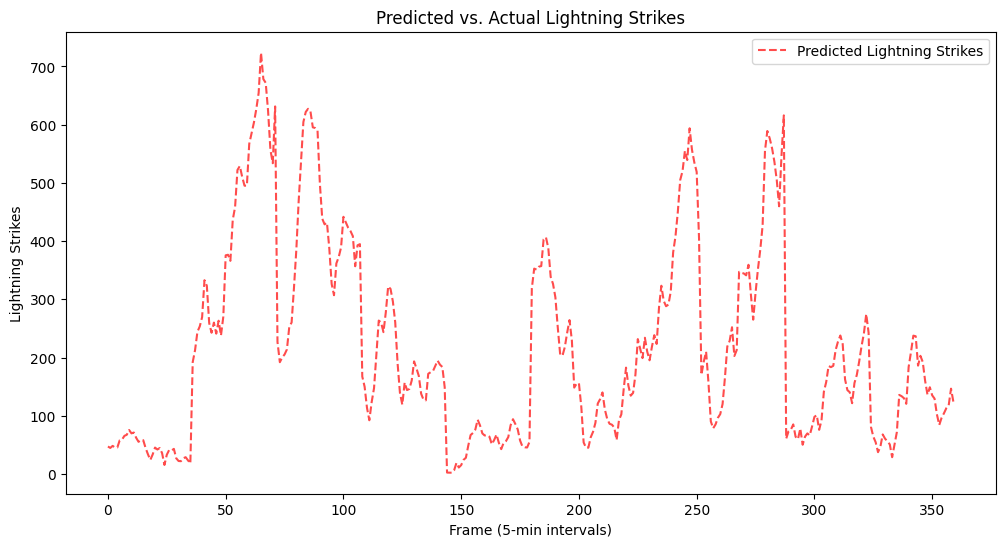

In [13]:
# Plot actual vs. predicted counts
plt.figure(figsize=(12, 6))
#plt.plot(actual_counts, label="Actual Lightning Strikes", color="blue", alpha=0.7)
plt.plot(predicted_counts, label="Predicted Lightning Strikes", color="red", linestyle="dashed", alpha=0.7)

plt.xlabel("Frame (5-min intervals)")
plt.ylabel("Lightning Strikes")
plt.title("Predicted vs. Actual Lightning Strikes")
plt.legend()
plt.show()

In [16]:
def distribute_flashes_randomly_over_time(event_index):
    """
    Distributes predicted flashes over 300 seconds per frame for an event specified by index.
    Ensures the output is sorted by time (`t`).

    Args:
        event_index (int): The index of the event in `test_dataset.event_ids`.

    Returns:
        torch.Tensor: A tensor of shape (10800, 3) with (t, x, y) for predicted flashes, sorted by `t`.
    """

    # **Retrieve the event ID using the index**
    if event_index >= len(test_dataset.event_ids):
        raise IndexError(
            f"Event index {event_index} is out of range. Max: {len(test_dataset.event_ids)-1}"
        )

    event_id = test_dataset.event_ids[event_index]
    print(f"Processing Event: {event_id}")

    # **Ensure event exists in predictions**
    if (
        event_id not in predicted_counts_per_event
        or event_id not in predicted_locations_per_event
    ):
        raise KeyError(f"Event ID {event_id} not found in predicted data.")

    num_frames = 36  # Each event has 36 frames
    seconds_per_frame = 300  # 5 minutes per frame
    total_seconds = num_frames * seconds_per_frame  # 10800 seconds

    flash_data = []  # Store (t, x, y) tuples

    for frame_idx in range(num_frames):
        start_time = frame_idx * seconds_per_frame  # Start second for the frame
        end_time = start_time + seconds_per_frame  # End second

        # **Retrieve predicted flashes and locations safely**
        predicted_flashes = (
            predicted_counts_per_event[event_id][frame_idx]
            if frame_idx < len(predicted_counts_per_event[event_id])
            else 0
        )
        predicted_locations = (
            predicted_locations_per_event[event_id][frame_idx]
            if frame_idx < len(predicted_locations_per_event[event_id])
            else []
        )

        if predicted_flashes == 0 or not predicted_locations:
            continue  # Skip empty frames

        # **Randomly assign times for flashes within the 300s window**
        flash_times = np.random.randint(start_time, end_time, size=predicted_flashes)
        flash_coords = np.array(
            predicted_locations[:predicted_flashes]
        )  # Get top `predicted_flashes` locations

        # **Ensure enough locations exist**
        if flash_coords.shape[0] < predicted_flashes:
            extra_needed = predicted_flashes - flash_coords.shape[0]
            extra_coords = np.random.choice(
                flash_coords, size=extra_needed, replace=True
            )
            flash_coords = np.vstack((flash_coords, extra_coords))

        # **Stack (t, x, y)**
        flash_data.extend(np.column_stack((flash_times, flash_coords)))

    # **Convert to Tensor**
    flash_tensor = torch.tensor(flash_data, dtype=torch.float32)

    # **Sort the tensor by `t` (column 0)**
    flash_tensor = flash_tensor[flash_tensor[:, 0].argsort()]

    return flash_tensor


In [18]:
num_frames_per_event = 36

model.eval()
actual_counts_per_event = {}
predicted_counts_per_event = {}
predicted_locations_per_event = {}

global_frame_idx = 0  # global counter that will go from 0 up to (#events * 36 - 1)

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)  # shape: (batch_size,)
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()

        # inputs.shape is (batch_size, channels, height, width)
        # so if batch_size > 1, we iterate over them individually
        for i in range(len(outputs)):
            event_idx = global_frame_idx // num_frames_per_event
            frame_idx = global_frame_idx % num_frames_per_event

            event_id = test_dataset.event_ids[event_idx]  # or however you store it

            # Initialize dictionaries
            if event_id not in actual_counts_per_event:
                actual_counts_per_event[event_id] = [None] * num_frames_per_event
                predicted_counts_per_event[event_id] = [None] * num_frames_per_event
                predicted_locations_per_event[event_id] = [None] * num_frames_per_event

            # Convert predicted flash count to an int
            predicted_flashes = int(max(0, round(outputs[i])))

            # Extract VIS and VIL images from the i-th sample
            vis_image = inputs[i, 3, :, :].cpu().numpy()  # Channel 3 = VIS
            vil_image = inputs[i, 0, :, :].cpu().numpy()  # Channel 0 = VIL

            # Compute predicted flash locations using VIS & VIL
            flash_locations = predict_flash_locations(vis_image, vil_image, predicted_flashes)

            # Store actual/predicted counts and locations *in the correct slot*
            actual_counts_per_event[event_id][frame_idx] = targets[i]
            predicted_counts_per_event[event_id][frame_idx] = predicted_flashes
            predicted_locations_per_event[event_id][frame_idx] = flash_locations

            # Move on to the next frame globally
            global_frame_idx += 1

print("All predictions stored successfully!")

All predictions stored successfully!


In [19]:
import os
import numpy as np

# **Create directory if it doesn't exist**
output_dir = "predictions_task3"
os.makedirs(output_dir, exist_ok=True)

# **Loop through all test events**
for event_index in range(len(test_dataset.event_ids)):
    # Get the event ID
    event_id = test_dataset.event_ids[event_index]

    print(f"Processing Event: {event_id}")

    # Generate lightning predictions (PyTorch Tensor)
    flash_tensor = distribute_flashes_randomly_over_time(event_index)

    # Convert to NumPy array (required for saving)
    flash_tensor = flash_tensor.cpu().numpy().astype(np.float32)  # Ensure float32 format

    # **Save the file with the correct name in the folder**
    filename = os.path.join(output_dir, f"Alberto-task3-lght-{event_id}.npy")
    np.save(filename, flash_tensor)

    # Print confirmation
    print(f"✅ Saved {filename} with shape {flash_tensor.shape}")

print("🚀 All prediction files saved successfully in 'predictions_task3/' folder!")

Processing Event: S839048
Processing Event: S839048
✅ Saved predictions_task3/Alberto-task3-lght-S839048.npy with shape (1580, 3)
Processing Event: S840965
Processing Event: S840965
✅ Saved predictions_task3/Alberto-task3-lght-S840965.npy with shape (15626, 3)
Processing Event: S843281
Processing Event: S843281
✅ Saved predictions_task3/Alberto-task3-lght-S843281.npy with shape (14729, 3)
Processing Event: S844280
Processing Event: S844280
✅ Saved predictions_task3/Alberto-task3-lght-S844280.npy with shape (6664, 3)
Processing Event: S846513
Processing Event: S846513
✅ Saved predictions_task3/Alberto-task3-lght-S846513.npy with shape (1855, 3)
Processing Event: S847595
Processing Event: S847595
✅ Saved predictions_task3/Alberto-task3-lght-S847595.npy with shape (7311, 3)
Processing Event: S848806
Processing Event: S848806


<ipython-input-16-cf47fa86de04>:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  flash_tensor = torch.tensor(flash_data, dtype=torch.float32)


✅ Saved predictions_task3/Alberto-task3-lght-S848806.npy with shape (10913, 3)
Processing Event: S849688
Processing Event: S849688
✅ Saved predictions_task3/Alberto-task3-lght-S849688.npy with shape (11316, 3)
Processing Event: S849871
Processing Event: S849871
✅ Saved predictions_task3/Alberto-task3-lght-S849871.npy with shape (5018, 3)
Processing Event: S852994
Processing Event: S852994
✅ Saved predictions_task3/Alberto-task3-lght-S852994.npy with shape (4243, 3)
🚀 All prediction files saved successfully in 'predictions_task3/' folder!


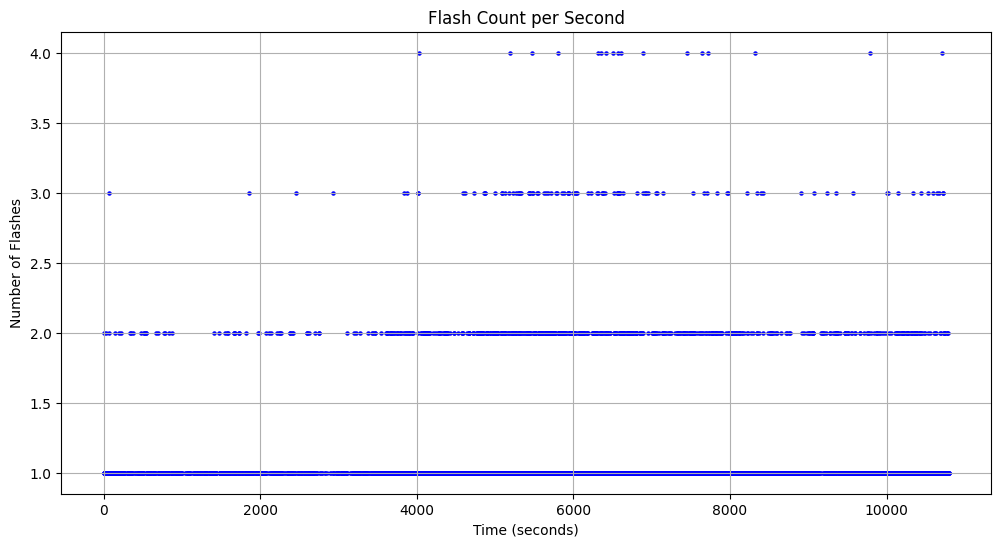

In [21]:
# Extract time values (first column)
time_values = flash_tensor[:, 0].astype(int)  # Convert to integer timestamps

# Count the number of flashes per second
unique_times, flash_counts = np.unique(time_values, return_counts=True)

# Plot the flash counts over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(unique_times, flash_counts, s=5, color="blue")  # Small dots
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Flashes")
plt.title("Flash Count per Second")
plt.grid(True)
plt.show()